# Extended Kalman Filter 1D_Version

EKF(Extended Kalman Filter、拡張カルマンフィルタ）はガウシアンフィルタの1つです。

位置推定を行う際にも用いられます。

本ページでは、1次元の直線上でロボットがランドマークを観測しながら（拡張）カルマンフィルタで自己位置を推定します。

1次元の直線上を移動するのは線形に移動しているので、結果的にカルマンフィルタを用いた自己位置推定と同じです。

注がある場合を除き、本ページに掲載されているコードはMITライセンスに、文章はクリエイティブ・コモンズ・ライセンスに基づいて公開します。

<a rel="license" href="http://creativecommons.org/licenses/by/4.0/"><img alt="クリエイティブ・コモンズ・ライセンス" style="border-width:0" src="https://i.creativecommons.org/l/by/4.0/88x31.png" /></a>

## Requirements

Python 3を必要とします。

## References

S. Thrun, W. Burgard and D. Fox (著), 上田 (訳): 確率ロボティクス, 毎日コミュニケーションズ, 2007

拡張カルマンフィルタでは状態遷移確率は$g$に、計測確率は$h$に（$g,h$はともに非線形関数）従うと仮定して次のようにモデル化します。

\begin{eqnarray}
x_t &=& g(u_t, x_{t-1})+\epsilon_t \\
z_t &=& h(x_t) + \delta_t
\end{eqnarray}

$g,h$ともに非線形であり、共分散行列を直接求めることができません。
テイラー展開によって線形近似することで、線形カルマンフィルタと同様に予測ステップと修正ステップを繰り返し、
システムを推定・制御することが可能になります。

## モジュールのインポート

In [1]:
# 数値計算及び描画に必要なモジュール
import numpy as np
import math, random
from copy import copy
from matplotlib import pyplot as plt

# アニメーション作成・表示に必要なモジュール
from matplotlib import animation
from IPython.display import HTML

## ランドマーククラス
ロボットにとって目印となるランドマークを宣言します。
ロボットはこのランドマークの座標をあらかじめ知っています。

In [2]:
class Landmarks:
    """
    landmarks = Landmarks([x1, x2, ... , x])
    引数にランドマークのX座標とY座標を配列で指定
    """
    def __init__(self, array):
        """
        ランドマークの座標を配列で取得
        あとで計算処理しやすくするため、numpyのarrayに変換
        """
        self.positions = np.array(array)
    
    def draw(self, subplot = plt):
        """
        取得したすべてのランドマークの座標をプロット
        """
        xs = [ e for e in self.positions ]
        ys = [ 0.0 for e in self.positions ]
        subplot.scatter(xs, ys, s=600, marker='*', label='landmarks', color='orange')

## ロボットのクラス

ロボットを操作および表示するためのクラスと、ロボットのモーションのためのクラスに分かれています。

ロボットを操作および表示するためのクラスでは座標を把握していません。実際のロボットは自身の座標を知り得ないためです。
ロボットのモーションのためのクラスでは、実際の位置を描画するためにロボットの座標を把握しています。

今回は説明用のグラフ描画のためのメンバもこのクラスで取り扱っています。

In [3]:
class Robot:
    """
    robot = Robot(0)
    ロボットの動作を決めるためのクラス
    ロボットは現在の自身の座標を把握できません。
    そのため、描画のための座標は別のクラスで管理します。
    """
    def __init__(self, x = 0):
        self.motion = RobotMotion(x)
        self.ekf = EKF(x, 0.09)
        self.sigma_translation_error = 0.1
    
    def move(self, distance):
        self.motion.updatePos(distance, self.sigma_translation_error)
        self.ekf.prediction_step(distance, self.motion.motion)
        
    def draw(self, subplot, obss):
        self.motion.draw(subplot, obss)

    def draw_graph(self, subplot, obss):
        self.motion.draw_graph(subplot, obss)
        x = np.arange(-0.5, 8, 0.0001)
        subplot.plot(x, self.generate_gaussian(self.ekf.bel_x_prev, self.ekf.cov_x_prev), color = 'green', label='bel_x (t-1)')
        subplot.plot(x, self.generate_gaussian(self.ekf.priori_bel_x, self.ekf.priori_cov_x), color = 'blue', label='priori_bel_x')
        subplot.plot(x, self.generate_gaussian(self.ekf.posteriori_bel_x, self.ekf.posteriori_cov_x), color = 'orange', label='posteriori_bel_x')
        
    def observation(self, landmarks):
        obss = self.motion.observation(landmarks)
        for obs in obss:
            self.ekf.update_step(obs[0].distance, landmarks.positions[obs[1]])
        return obss

    def generate_gaussian(self, bel, cov):
        x = np.arange(-0.5, 8, 0.0001)
        return np.exp(-(bel - x) ** 2 / (2 * cov)) / np.sqrt(2 * np.pi * cov) 

class RobotMotion:
    """
    ロボットの描画のためのクラス
    ロボットの動作を決めるのはこのクラスではありません。
    """
    def __init__(self, x):
        """
        ロボットの座標、角度を配列で取得、保存
        あとで計算処理しやすくするため、numpyのarrayに変換
        """
        self.actual_poses = [np.array(x)]
        
    def draw(self, subplot, obss, color = 'red',label = 'actual robot motion'):
        """
        ロボットの位置情報を元にベクトルを描画
        """
        xs = self.actual_poses[-1]
        ys = 0.0
        vxs = 0.5
        vys = 0.0
        sub_color = color
        sub_label = label
        subplot.quiver(xs, ys, vxs, vys, color = sub_color, label = sub_label)

    def draw_graph(self, subplot, obss, color = 'red',label = 'actual robot motion'):
        """
        ロボットの位置情報を元にベクトルを描画
        """
        xs = self.actual_poses[-1]
        ys = 0.0
        sub_color = color
        sub_label = label
        subplot.scatter(xs, ys, s = 100, marker = '^',color = sub_color, label = sub_label)

    def motion(self, robot_pos, distance, sigma):
        """
        ロボットを移動
        進む距離、進む角度を元に移動する先の座標をnumpyのarray形式で返す
        """
        # 移動距離にsigma分の標準偏差（10%など）
        actual_distance = random.gauss(distance, distance * sigma)
        return robot_pos + actual_distance
        
    def updatePos(self, distance, sigma):
        """
        ロボットとパーティクルを移動
        進む距離、進む角度を元に位置情報を更新
        """
        self.actual_poses.append(np.array(self.motion(self.actual_poses[-1], distance, sigma)))
        
    def observation(self, landmarks):
        obss = []
        # すべてのランドマークについて、観測できるか確認
        for i,landmark in enumerate(landmarks.positions):
            # ランドマークの観測結果を保存
            obs = Observation(landmark)
            obs.measure(self.actual_poses[-1])
            # センサの範囲内だったランドマークをリストに追加
            if obs.distance != None:
                obss.append([obs, i])

        # 観測結果をリストで返す
        return obss

# カルマンフィルタのクラス

本ページでは1次元の直線上を移動するロボットの自己位置推定を行っています。直線上の移動の場合、非線形関数を線形近似する段階がありません。一般的なカルマンフィルタと同じ計算をしています。

In [4]:
class EKF:
    """
    EKF
    """
    def __init__(self, robot_pos, cov):
        # ロボットの雑音：ロボットのクラスで定義されている値と近いほど正確な位置予測ができる
        # ロボットの制御入力に対する雑音の標準偏差
        self.sigma_robot_translation_error = 0.1
        # ロボットの観測に対する雑音の標準偏差
        self.sigma_robot_observation_error = 0.1
        # 初回の事前推定値を計算するための事後推定値
        # 推定位置の初期位置（初期信念）
        self.posteriori_bel_x = robot_pos
        # 初回の事前誤差共分散を計算するための事後誤差共分散
        # 推定値の初期位置の分散（標準偏差**2）
        self.posteriori_cov_x = cov
        
    def prediction_step(self, distance, motion):
        # 1つ前の時間の状態を保存
        self.bel_x_prev = self.posteriori_bel_x
        self.cov_x_prev = self.posteriori_cov_x
        # 1つ前の時間の事後推定値を元に、事前推定値を計算
        self.priori_bel_x = motion(self.bel_x_prev, distance, self.sigma_robot_translation_error)
        # 1つ前の時間の事後誤差共分散を元に、事前誤差共分散を計算
        self.priori_cov_x = self.cov_x_prev + self.sigma_robot_translation_error ** 2
        
        # ランドマークを観測できなかったとき用
        self.posteriori_bel_x = self.priori_bel_x
        self.posteriori_cov_x = self.priori_cov_x
        
    def update_step(self, obs, landmark):
        # カルマンゲイン
        kalman_gain = self.priori_cov_x / (self.priori_cov_x + self.sigma_robot_observation_error ** 2)
        # 事後推定値
        self.posteriori_bel_x = self.priori_bel_x + kalman_gain * (abs(landmark - self.priori_bel_x) - obs)
        #print(obs ,landmark, self.priori_bel_x, (landmark - self.priori_bel_x))
        # 事後誤差共分散
        self.posteriori_cov_x = (1 - kalman_gain) * self.priori_cov_x

# 観測のためのクラス

ランドマークを観測するためのクラスです。
ロボットの現在地からセンサの観測範囲内にランドマークがあるかどうかをチェックします。

In [5]:
class Observation:
    """
    ロボットの観測モデル
    """
    def __init__(self, landmark_pos, max_range = 1.0, min_range = 0.1, sigma = 0.1):
        # ランドマークの位置を保存
        self.landmark_x = landmark_pos
        # センサの計測できる範囲を設定
        self.sensor_max_range = max_range
        self.sensor_min_range = min_range
        # センサの観測値の雑音の標準偏差
        self.sigma_obs_error = sigma
        
        # 観測できない場合のセンサ値を決めておく（ここではNone）
        # 観測できた場合はこの値を上書きする
        self.distance, self.direction, self.error_ellipse = None, None, None

    def measure(self, robot_pos):
        """
        センサの値を取得してセンサの観測範囲内に対象物があるかチェックする
        """
        # ロボットの位置(ロボット自身は観測不可能)を一時保存
        robot_x = robot_pos
        
        # センサの計測距離範囲内かどうか確認する
        distance = math.sqrt((robot_x - self.landmark_x) ** 2)
        if not distance < self.sensor_max_range and distance > self.sensor_min_range:
            self.lid = None
            return
        
        # 真値に混入する雑音の大きさ（標準偏差）を設定
        # 標準設定 : 距離に対して10%の標準偏差
        sigma_distance = distance * self.sigma_obs_error
        
        # 雑音を混ぜてセンサの値とする
        actual_distance = random.gauss(distance, sigma_distance)   
     
        self.distance = actual_distance

シミュレーションを行います。

ロボットはランドマークをまたぐのでランドマークの上を通過します。

1つ前の時間の推定値（信念）を `bel_x(t-1)` として、予測ステップ後の事前推定値を `priori_bel_x` として、修正ステップ後の事後推定値を `posteriori_bel_` として表します。

In [6]:
# 新規ウィンドウと座標軸用subplotを用意
# タイトルは個別につけるので今は指定しない
fig, (world, graph) = plt.subplots(2, sharex=True, figsize=(12, 12))

# ランドマークの座標を指定
landmarks = Landmarks([3.0, 4.0, 7.0])

# ロボットの座標を指定
robot = Robot(0)

# アニメーション作成の初期処理
# 初期処理を指定しないと、更新処理が1回分多く呼び出される
def init():
    pass

# アニメーション作成の更新処理
def update(i):
    # 座標軸用subplotの描画内容を一度クリア
    world.cla()
    graph.cla()
    # 座標軸の範囲を指定
    world.set_xlim(-0.5, 8.0)
    world.set_ylim(-0.5, 0.5)
    graph.set_ylim(0.0, 10.0)
    # ランドマークを描画
    landmarks.draw(world)
    # ロボットを移動
    robot.move(0.2)
    # 移動後の位置でランドマークを観測
    obss = robot.observation(landmarks)
    # ロボットを描画
    robot.draw(world, obss)
    robot.draw_graph(graph, obss)
    # タイトルを追加
    world.set_title("Robot Motion : frame{0:04d}".format(i))
    graph.set_title("bel")
    # 左上に凡例を追加
    world.legend(loc='upper left')
    graph.legend(loc='upper left')

# アニメーションの作成
anim = animation.FuncAnimation(fig, update, init_func=init, interval = 1000, frames = 40)

In [7]:
HTML(anim.to_html5_video())

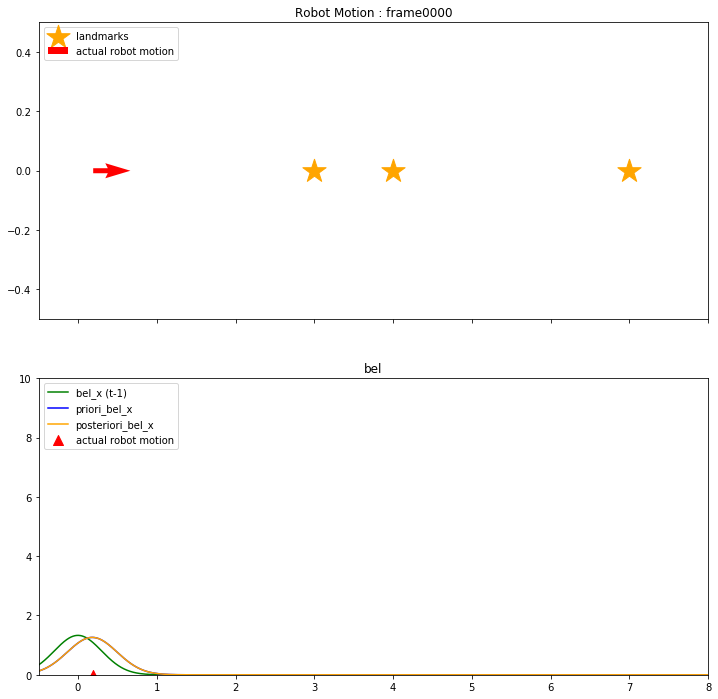

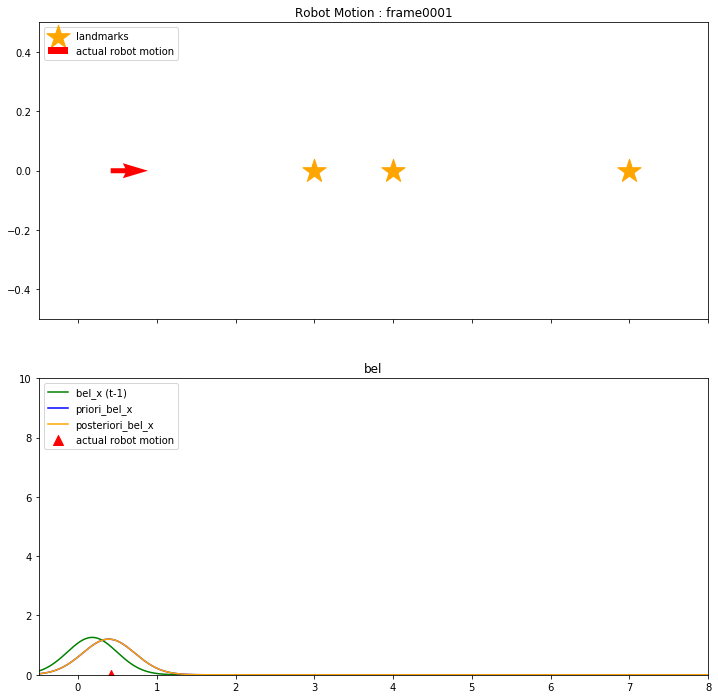

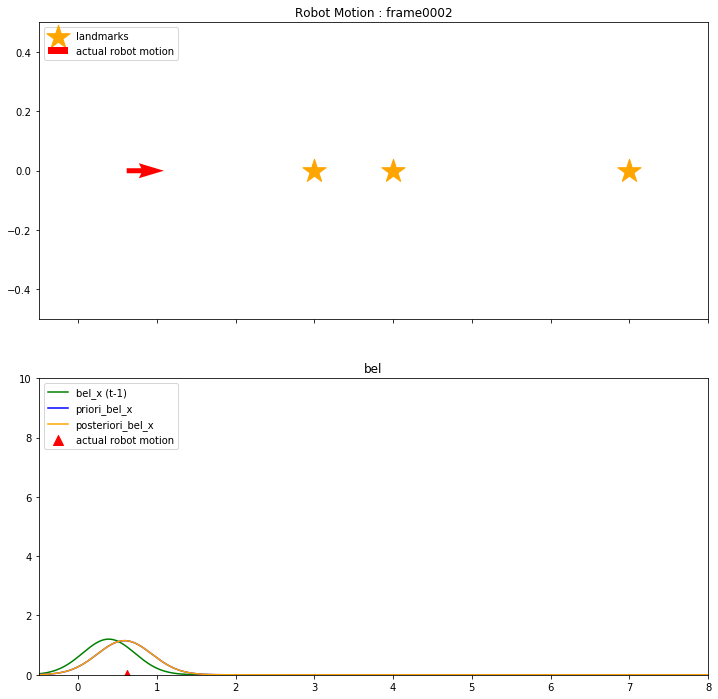

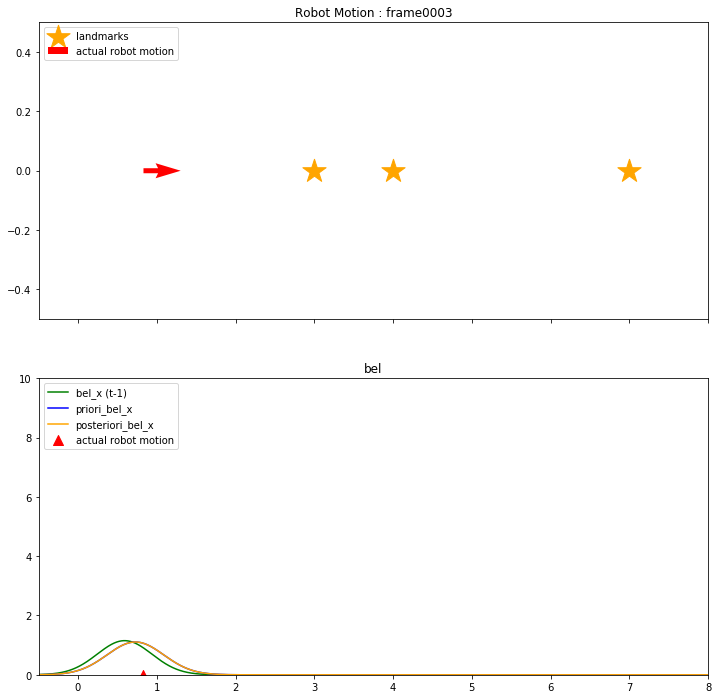

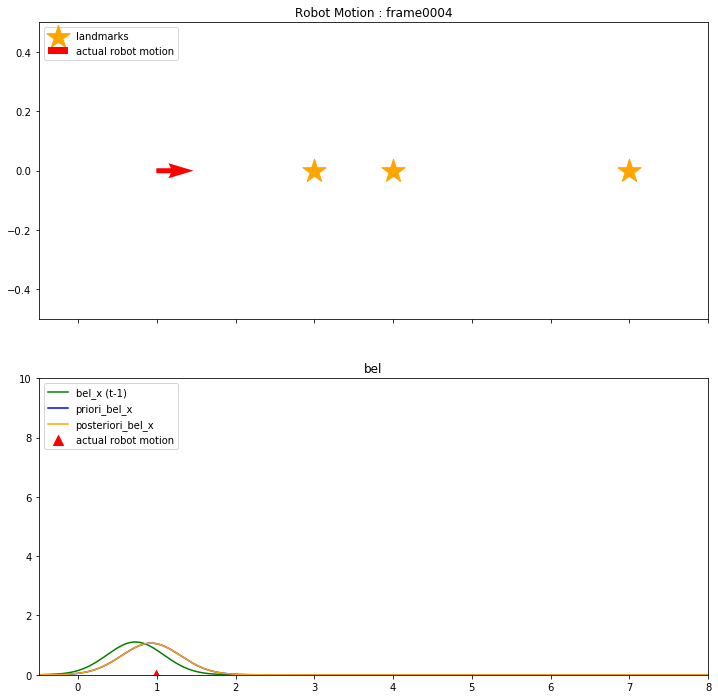

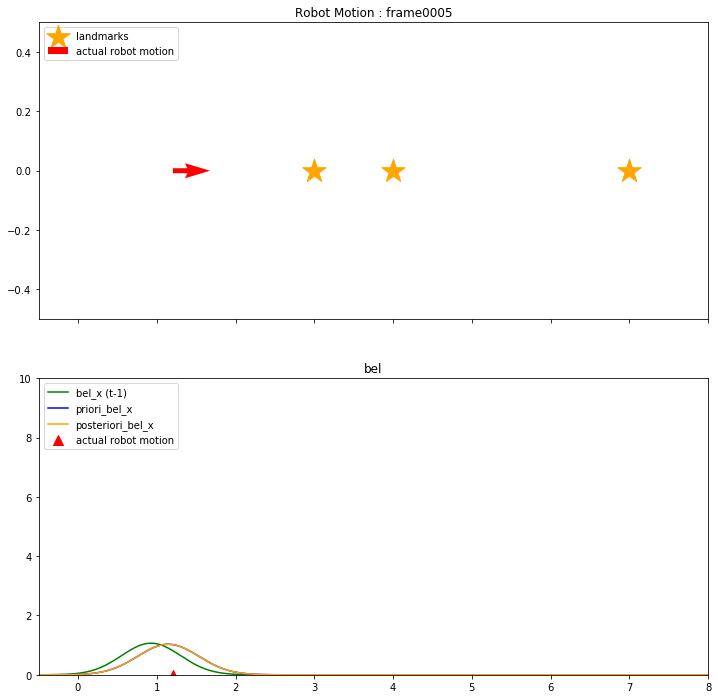

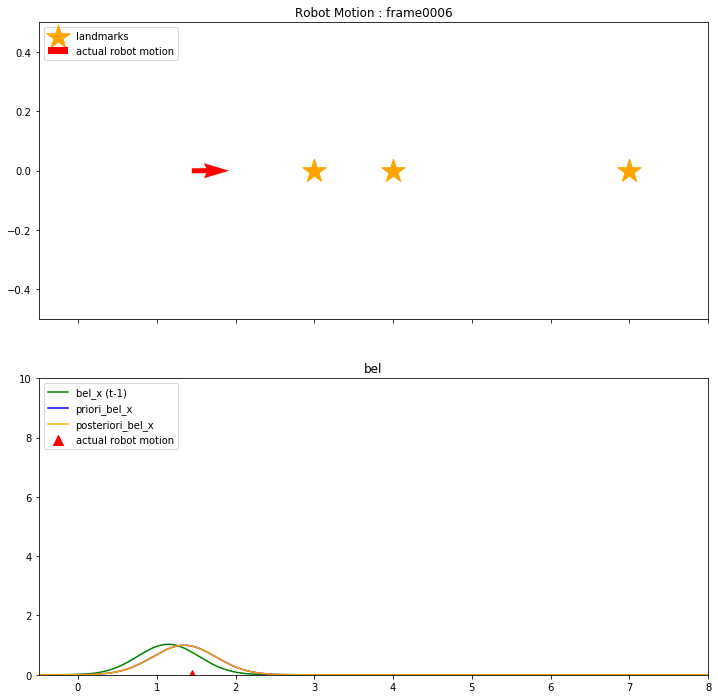

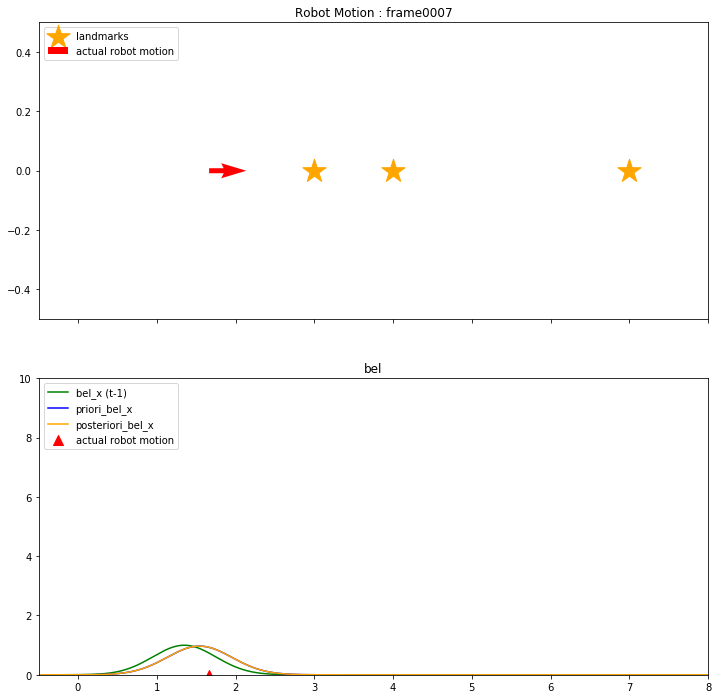

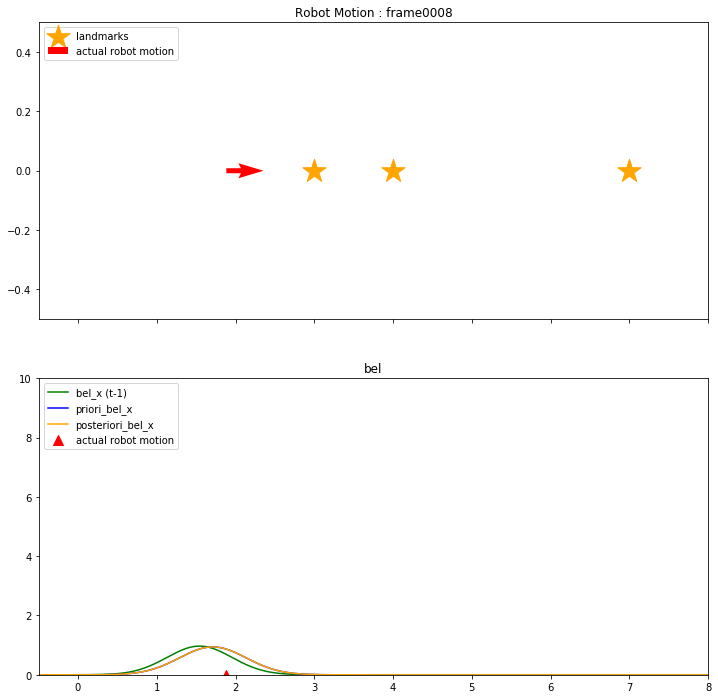

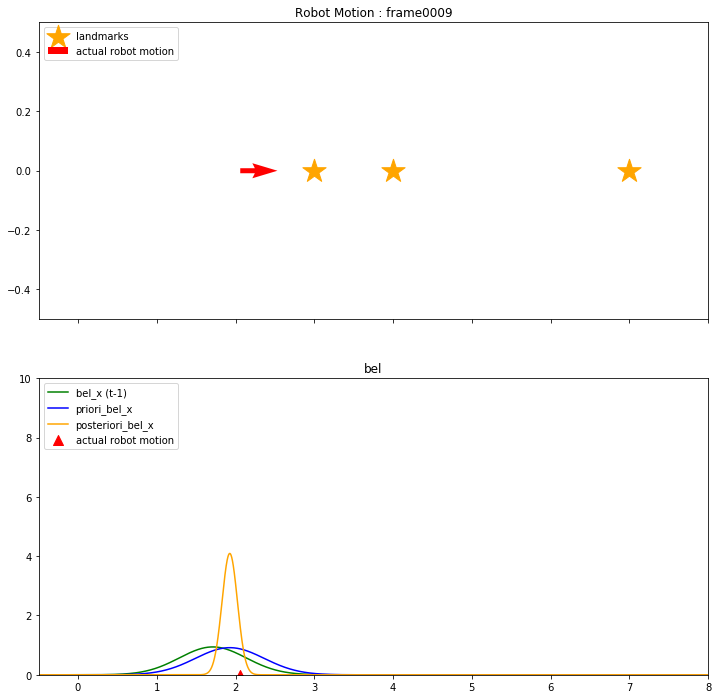

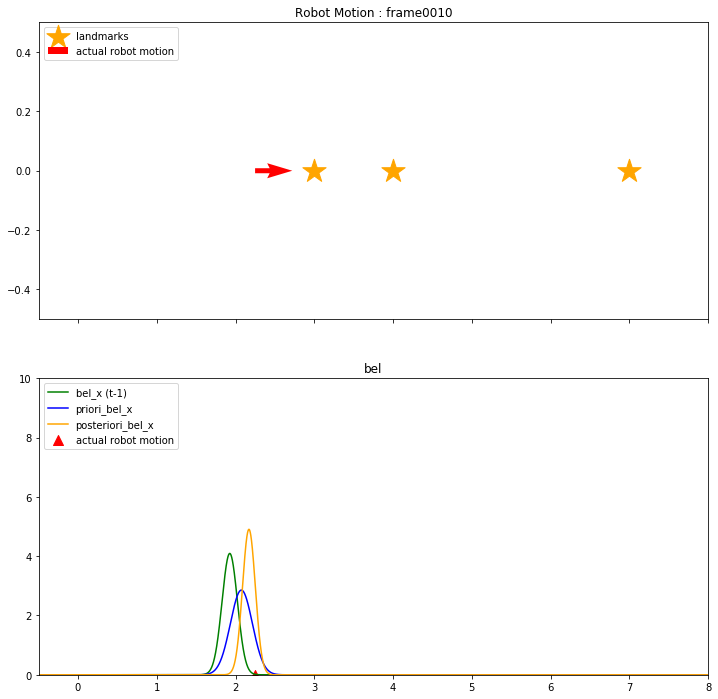

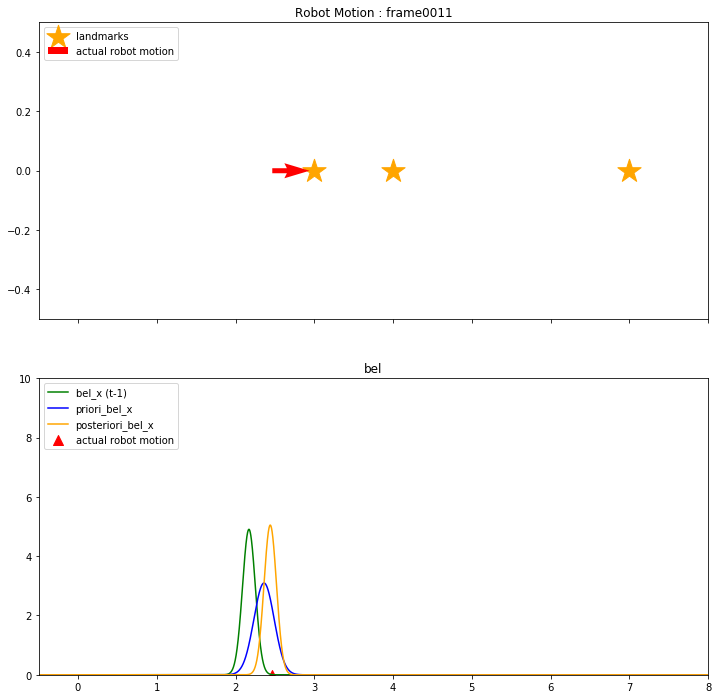

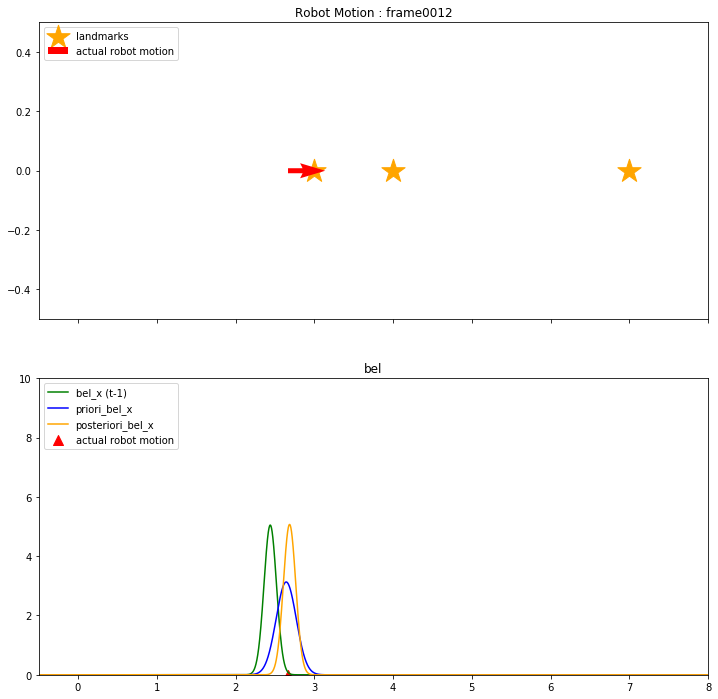

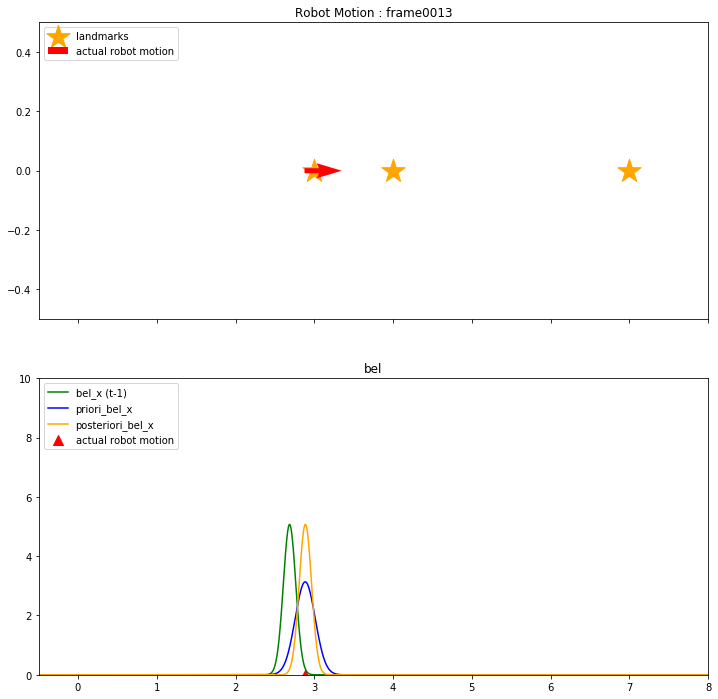

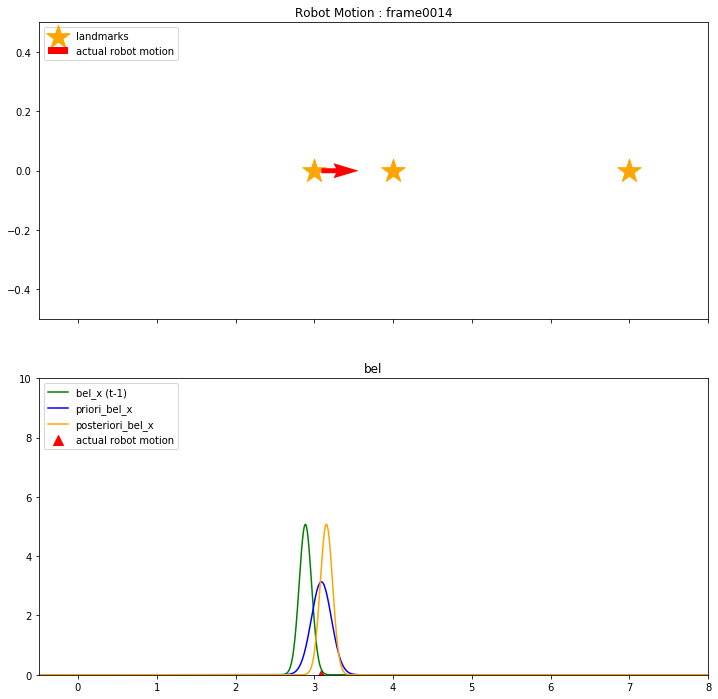

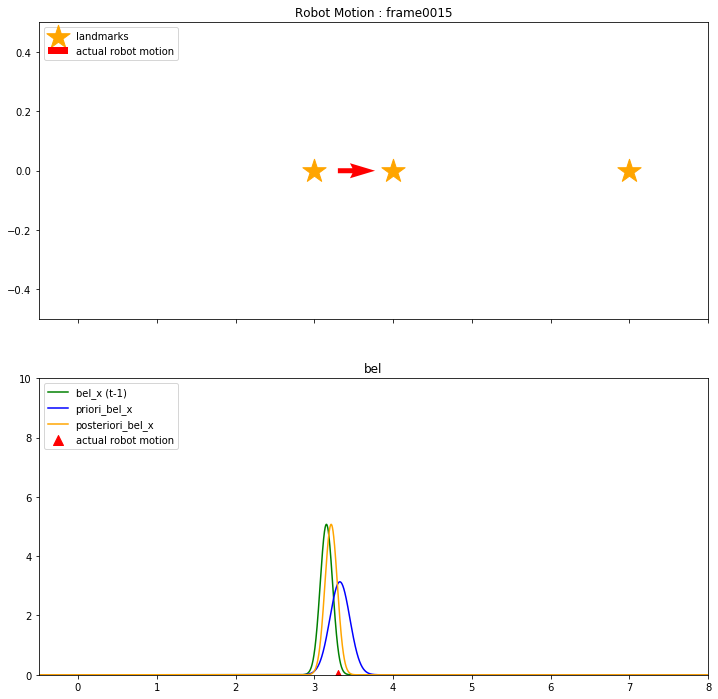

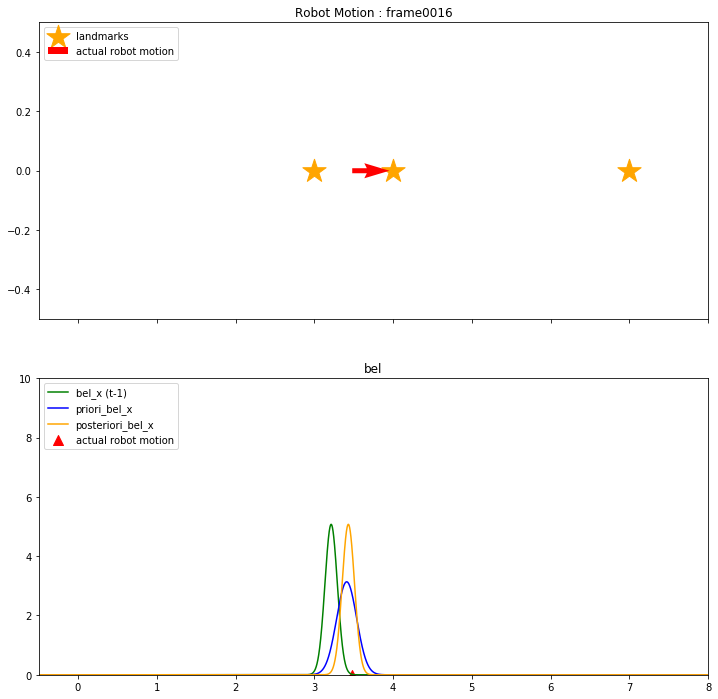

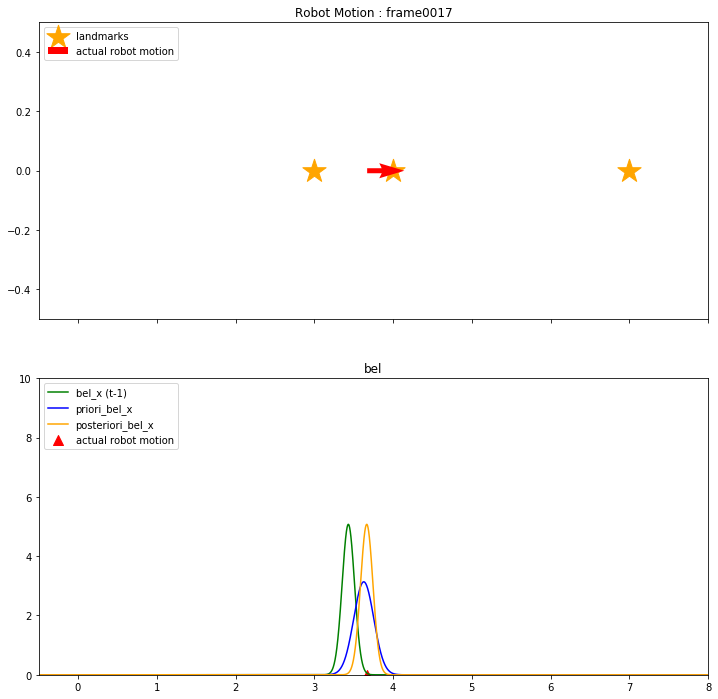

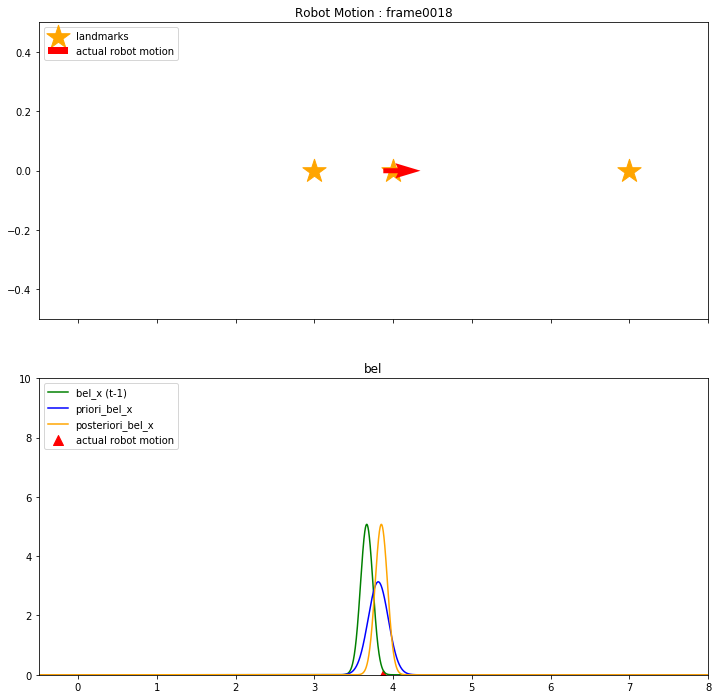

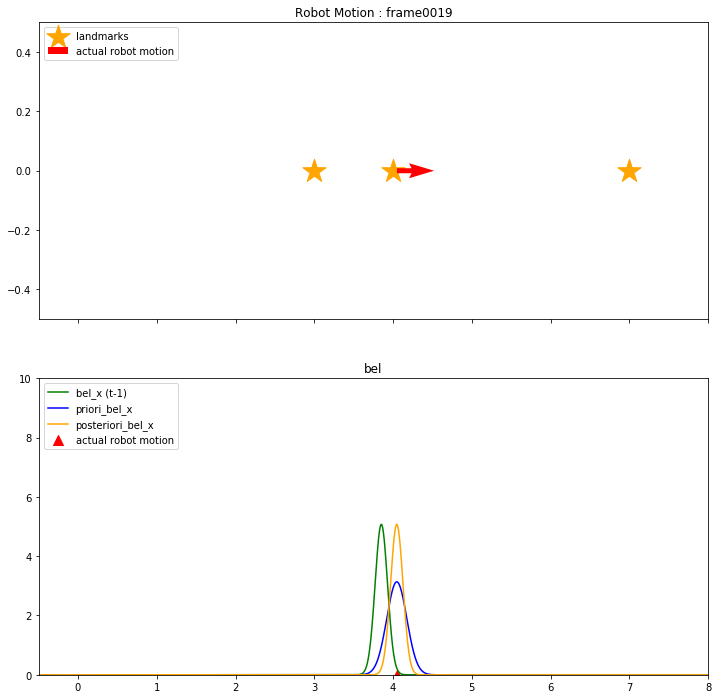

In [8]:
# figureの初期化
plt.close()

# ランドマークの座標を指定
landmarks = Landmarks([3.0, 4.0, 7.0])

# ロボットの座標を指定
robot = Robot(0)

# アニメーション作成の更新処理
def update(i):
    # 新規ウィンドウと座標軸用subplotを用意
    # タイトルは個別につけるので今は指定しない
    fig, (world, graph) = plt.subplots(2, sharex=True, figsize=(12, 12))
    # 座標軸の範囲を指定
    world.set_xlim(-0.5, 8.0)
    world.set_ylim(-0.5, 0.5)
    graph.set_ylim(0.0, 10.0)
    # ランドマークを描画
    landmarks.draw(world)
    # ロボットを移動
    robot.move(0.2)
    # 移動後の位置でランドマークを観測
    obss = robot.observation(landmarks)
    # ロボットを描画
    robot.draw(world, obss)
    robot.draw_graph(graph, obss)
    # タイトルを追加
    world.set_title("Robot Motion : frame{0:04d}".format(i))
    graph.set_title("bel")
    # 左上に凡例を追加
    world.legend(loc='upper left')
    graph.legend(loc='upper left')

# アニメーションの作成
for i in range(0, 20):
    update(i)
    plt.show()